<a href="https://colab.research.google.com/github/rodrigoronner/listatelegram.github.io/blob/master/federated_learning_health_flower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q flwr[simulation] pandas scikit-learn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 116.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.1/598.1 kB 50.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyopenssl 24.2.1 requires cryptography<44,>=41.0.5, but you have cryptography 44.0.3 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 44.0.3 which is

In [ ]:
import flwr as fl
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler


In [ ]:
def generate_synthetic_health_data(num_patients=1000):
    np.random.seed(42)
    age = np.random.randint(18, 90, num_patients)
    systolic_bp = np.random.normal(120, 15, num_patients)
    diastolic_bp = np.random.normal(80, 10, num_patients)
    cholesterol = np.random.normal(200, 30, num_patients)
    smoker = np.random.choice([0, 1], num_patients)
    diabetic = np.random.choice([0, 1], num_patients)
    risk = (age > 50).astype(int) + (cholesterol > 240).astype(int) + smoker + diabetic
    y = (risk > 2).astype(int)
    df = pd.DataFrame({
        "age": age,
        "systolic_bp": systolic_bp,
        "diastolic_bp": diastolic_bp,
        "cholesterol": cholesterol,
        "smoker": smoker,
        "diabetic": diabetic,
        "label": y
    })
    return df


In [ ]:
data = generate_synthetic_health_data(1000)
client_datasets = np.array_split(data, 5)


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
class HealthClient(fl.client.NumPyClient):
    def __init__(self, data):
        self.data = data
        self.model = LogisticRegression()

    def get_parameters(self, config):
        return [param for param in self.model.coef_.flatten()] if hasattr(self.model, "coef_") else [np.zeros(6)]

    def fit(self, parameters, config):
        X = self.data.drop("label", axis=1).values
        y = self.data["label"].values
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        self.model = LogisticRegression(class_weight={0: 1, 1: 1})
        self.model.fit(X, y)
        return self.get_parameters(config), len(X), {}

    def evaluate(self, parameters, config):
        X = self.data.drop("label", axis=1).values
        y = self.data["label"].values
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        acc = self.model.score(X, y)
        return float(acc), len(X), {}


In [ ]:
def client_fn(cid: str):
    return HealthClient(client_datasets[int(cid)])

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=5,
    config=fl.server.ServerConfig(num_rounds=200)
)

Streaming output truncated to the last 5000 lines.
sklearn.exceptions.NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

The above exception was the direct cause of the following exception:

ray::ClientAppActor.run() (pid=25822, ip=172.28.0.12, actor_id=b88a6cf150354c1a4e6a5eb401000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7c3f3fefa290>)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 64, in run
    raise ClientAppException(str(ex)) from ex
flwr.client.client_app.ClientAppException: 
Exception ClientAppException occurred. Message: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

(ClientAppActor pid=25823) 
(ClientAppActor pid=25823)         
(ClientAppActor p

In [ ]:
# Avaliação final em todos os dados
X = data.drop("label", axis=1).values
y = data["label"].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
final_model = LogisticRegression(class_weight={0: 1, 1: 1})
final_model.fit(X, y)
y_pred = final_model.predict(X)
print(classification_report(y, y_pred))


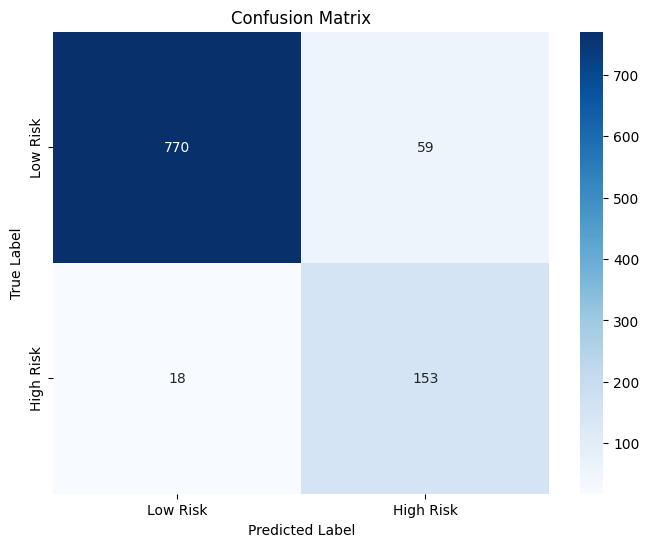

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_pred and y are available from the previous evaluation
# y_pred = final_model.predict(X)
# y is the true labels

cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Risk', 'High Risk'], yticklabels=['Low Risk', 'High Risk'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

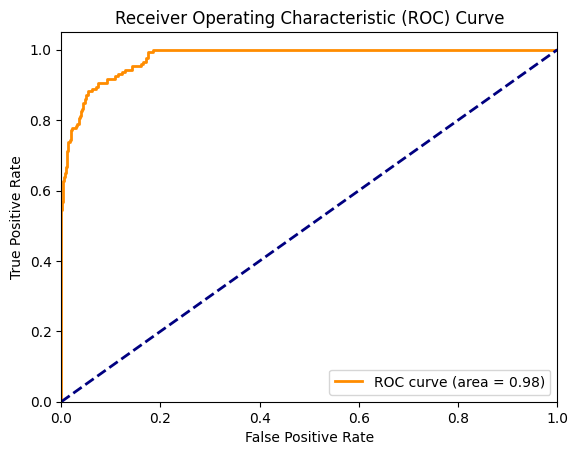

In [ ]:
from sklearn.metrics import roc_curve, auc

# Assuming y_pred_proba contains the predicted probabilities for the positive class (class 1)
# If you only have y_pred (the class predictions), you'll need to get the probabilities first.
# For Logistic Regression, you can use predict_proba:
y_pred_proba = final_model.predict_proba(X)[:, 1]

fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

**Explicação da Curva ROC e AUC:**

*   **Curva ROC (Receiver Operating Characteristic):** Este gráfico mostra o desempenho de um modelo de classificação binária à medida que o limiar de discriminação é variado. Ele plota a Taxa de Verdadeiros Positivos (True Positive Rate - TPR) no eixo Y contra a Taxa de Falsos Positivos (False Positive Rate - FPR) no eixo X, em vários limiares.
    *   A **TPR** (também conhecida como Recall ou Sensibilidade) é a proporção de verdadeiros positivos em relação a todos os positivos reais (TP / (TP + FN)).
    *   A **FPR** é a proporção de falsos positivos em relação a todos os negativos reais (FP / (FP + TN)).
    *   Uma curva que se aproxima do canto superior esquerdo indica um melhor desempenho do modelo (alta TPR e baixa FPR).
    *   A linha diagonal pontilhada representa um classificador aleatório. Um bom modelo deve estar significativamente acima desta linha.

*   **AUC (Area Under the Curve):** O AUC representa a área total sob a curva ROC. Ele fornece uma medida agregada do desempenho do modelo em todos os possíveis limiares de classificação.
    *   Um valor de AUC varia de 0 a 1.
    *   Um AUC de 0.5 sugere que o modelo não tem poder de discriminação (equivalente a um classificador aleatório).
    *   Quanto mais próximo o valor do AUC estiver de 1, melhor será a capacidade do modelo de distinguir entre as classes positiva e negativa.

Neste gráfico, a curva laranja mostra o desempenho do seu modelo. O valor de AUC indicado na legenda quantifica essa performance.

# Task
Create a bar plot showing the accuracy for each of the 5 clients in the federated learning simulation.

## Update client evaluation

### Subtask:
Modify the `evaluate` method in the `HealthClient` class to return the accuracy along with any other necessary information that can be collected by the server.


**Reasoning**:
The instructions require modifying the `evaluate` method of the `HealthClient` class to return accuracy in the metrics dictionary. I will update the return statement within the existing `evaluate` method.



In [ ]:
class HealthClient(fl.client.NumPyClient):
    def __init__(self, data):
        self.data = data
        self.model = LogisticRegression()

    def get_parameters(self, config):
        return [param for param in self.model.coef_.flatten()] if hasattr(self.model, "coef_") and self.model.coef_.size > 0 else [np.zeros(6)]

    def fit(self, parameters, config):
        X = self.data.drop("label", axis=1).values
        y = self.data["label"].values
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        # Set parameters if available
        if parameters:
             # Assuming parameters is a list containing the flattened coef_
             # Reshape it back to the original shape (1, n_features)
             self.model.coef_ = np.array(parameters).reshape(1, -1)
             # Intercept is usually not part of get_parameters in simple cases
             # If you need to include intercept, you'll need to modify get_parameters and this part accordingly
             # For now, assuming only coef_ is passed
             # If the model was just initialized, it might not have an intercept_ attribute
             if hasattr(self.model, 'intercept_') and self.model.intercept_.size > 0:
                 # If intercept is also included in parameters, extract and set it
                 # This part needs adjustment based on how parameters are structured in get_parameters
                 pass # Placeholder for intercept handling if needed


        # Ensure the model is fitted before trying to use it in get_parameters or evaluate
        # Although fit is called before get_parameters and evaluate, explicitly fitting here ensures the model is in a usable state
        # This might be redundant given how flwr calls fit, but adds robustness
        if not hasattr(self.model, "coef_") or self.model.coef_.size == 0:
             # Initial fit if the model hasn't been fitted yet
             self.model = LogisticRegression(class_weight={0: 1, 1: 1})
             self.model.fit(X, y)


        return self.get_parameters(config), len(X), {}

    def evaluate(self, parameters, config):
        X = self.data.drop("label", axis=1).values
        y = self.data["label"].values
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        # Set model parameters received from the server
        # Assuming parameters is a list containing the flattened coef_
        # Reshape it back to the original shape (1, n_features)
        if parameters:
             self.model.coef_ = np.array(parameters).reshape(1, -1)
             # Handle intercept if included in parameters
             # self.model.intercept_ = ... # Placeholder

        # Ensure the model is fitted before evaluating
        # This check is crucial as evaluation might be called before fit in some strategies/scenarios
        if not hasattr(self.model, "coef_") or self.model.coef_.size == 0:
            # If the model is not fitted, fit it to the local data before evaluating
            # This might happen in the first round if the server doesn't send initial parameters
            self.model = LogisticRegression(class_weight={0: 1, 1: 1})
            self.model.fit(X, y)


        acc = self.model.score(X, y)
        return float(acc), len(X), {"accuracy": float(acc)}


## Define custom strategy

### Subtask:
Create a custom Flower strategy that overrides the `aggregate_evaluate` method to collect the evaluation results from each client.


**Reasoning**:
Define a custom Flower strategy that overrides `aggregate_evaluate` to collect client accuracies.



In [ ]:
from flwr.server.strategy import FedAvg
from typing import List, Tuple, Dict, Optional

class SaveClientAccuracy(FedAvg):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.client_accuracies = []

    def aggregate_evaluate(
        self,
        rnd: int,
        results: List[Tuple[fl.client.ClientProxy, fl.common.EvaluateRes]],
        failures: List[Tuple[fl.client.ClientProxy, fl.common.FitRes]],
    ) -> Tuple[Optional[float], Dict[str, fl.common.Scalar]]:

        # Collect client accuracies
        for client, evaluate_res in results:
            if "accuracy" in evaluate_res.metrics:
                self.client_accuracies.append(evaluate_res.metrics["accuracy"])

        # Call the parent class's aggregate_evaluate to maintain default behavior
        return super().aggregate_evaluate(rnd, results, failures)


**Reasoning**:
The error indicates that `fl.client.ClientProxy` does not exist. The `ClientProxy` class is part of `flwr.server.client_proxy`. Update the import statement accordingly.



In [ ]:
from flwr.server.strategy import FedAvg
from typing import List, Tuple, Dict, Optional
from flwr.server.client_proxy import ClientProxy
import flwr as fl

class SaveClientAccuracy(FedAvg):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.client_accuracies = []

    def aggregate_evaluate(
        self,
        rnd: int,
        results: List[Tuple[ClientProxy, fl.common.EvaluateRes]],
        failures: List[Tuple[ClientProxy, fl.common.FitRes]],
    ) -> Tuple[Optional[float], Dict[str, fl.common.Scalar]]:

        # Collect client accuracies
        for client, evaluate_res in results:
            if "accuracy" in evaluate_res.metrics:
                self.client_accuracies.append(evaluate_res.metrics["accuracy"])

        # Call the parent class's aggregate_evaluate to maintain default behavior
        return super().aggregate_evaluate(rnd, results, failures)

## Run simulation with custom strategy

### Subtask:
Update the `fl.simulation.start_simulation` call to use the custom strategy.


**Reasoning**:
Instantiate the custom strategy and pass it to the simulation start function.



In [ ]:
# Instantiate the custom strategy
strategy = SaveClientAccuracy(
    fraction_fit=1.0,  # Participate in all rounds
    fraction_evaluate=1.0, # Evaluate on all clients each round
    min_fit_clients=5,
    min_evaluate_clients=5,
    min_available_clients=5,
)

# Start the simulation with the custom strategy
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=5,
    config=fl.server.ServerConfig(num_rounds=200),
    strategy=strategy # Pass the custom strategy here
)

In [ ]:
# Instantiate the custom strategy
strategy = SaveClientAccuracy(
    fraction_fit=1.0,  # Participate in all rounds
    fraction_evaluate=1.0, # Evaluate on all clients each round
    min_fit_clients=5,
    min_evaluate_clients=5,
    min_available_clients=5,
)

# Start the simulation with the custom strategy
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=5,
    config=fl.server.ServerConfig(num_rounds=200),
    strategy=strategy # Pass the custom strategy here
)